# Write your neural network in python from scratch

* Write your NN and implement the backpropagation to learn
* Use the Donut Exmple with noise for training and test
* Show the decision region using plot_decision_regions

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib
matplotlib.rcParams['figure.figsize'] = [7, 7]
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
# data
def donut_data(N,noise=0.8):
    X = np.random.randn(N, 2)
    X_r = X + np.random.uniform(-noise,noise,X.shape)
    Y = np.logical_or(X_r[:, 0]*X_r[:, 0] + X_r[:, 1]*X_r[:, 1] < 0.3, X_r[:, 0]*X_r[:, 0] + X_r[:, 1]*X_r[:, 1]> 2)
    Y = np.where(Y, 1, 0)
    return X, Y

def plot_data(X,Y,c1='b',c2='r', toplot=True):
    plt.scatter(X[Y==1, 0], X[Y==1, 1],c=c1, marker='x', label='1')
    plt.scatter(X[Y==0, 0], X[Y==0, 1],c=c2, marker='s', label='0')
    if toplot:
        plt.ylim(-3.0, 3.0)
        plt.xlim(-3.0, 3.0)
        plt.legend()
        #plt.show()

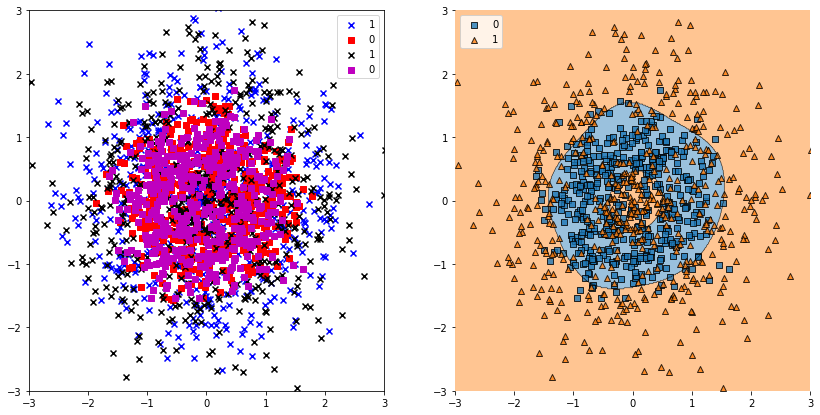

In [2]:
N = 1000
noise = 0.5
XL, yL = donut_data(N, noise)
XT, yT = donut_data(N, noise)
plt.figure(figsize=(14,7))

from sklearn.svm import SVC
svc = SVC(kernel='rbf',C=10)
svc.fit(XL,yL)

plt.subplot(1,2,1)
plot_data(XL,yL,'b','r',False)
plot_data(XT,yT,'k','m', True)

plt.subplot(1,2,2)
plot_decision_regions(XT, yT, svc)
plt.ylim(-3.0, 3.0)
plt.xlim(-3.0, 3.0)
plt.legend(loc='upper left')
plt.show()


# Shallow neural network #
We define a class for a shallow (2 layers) neural network, a neural network with:
- input layer
- 1 hidden layer: activation function --> relu (function that returns 0 if x<0 and x otherwise)
- output layer: activation function --> sigmoid



In [3]:
#depth is the number of layers: depth = 2
class ShallowNetwork():
    
    #initializations of parameters    
    def __init__(self, layers=[2,8,1], learning_rate=0.001, iterations=100):
        self.params = {}
        self.layers = layers
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.loss = []
        self.eps=0.0001 #risolve i problemi delle divisioni per 0
        self.sample_size = None
        self.X = None
        self.y = None
                
    
    def init_weights(self):
        np.random.seed(1) # Seed the random number generator
        self.params["W1"] = np.random.randn(self.layers[0], self.layers[1]) 
        self.params['b1'] = np.random.randn(self.layers[1],)
        self.params['W2'] = np.random.randn(self.layers[1],self.layers[2]) 
        self.params['b2'] = np.random.randn(self.layers[2],)
        
    def relu(self,Z):
        return np.maximum(0, Z) 
        
    def sigmoid(self,x):
        sigma=1/(1+np.exp(-x))
        return sigma
    
    def cross_entropy_loss(self,y, yhat):
        nsample = len(y)
        loss = -1/nsample * (np.sum(np.multiply(np.log(yhat+self.eps), y+self.eps) + np.multiply((1 - y+self.eps), np.log(1 - yhat+self.eps))))
        return loss

    def forward_propagation(self):
        
        Z1 = self.X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        yhat = self.sigmoid(Z2)
        loss = self.cross_entropy_loss(self.y,yhat)

        # save calculated parameters     
        self.params['Z1'] = Z1
        self.params['Z2'] = Z2
        self.params['A1'] = A1
        return yhat,loss

    
    def back_propagation(self,yhat):
        '''
        Computes the derivatives and update weights and bias according.
        '''
        def dRelu(x):
            x[x<=0] = 0
            x[x>0] = 1
            return x
        
        dl_wrt_yhat = -(np.divide(self.y,yhat+self.eps) - np.divide((1 - self.y),(1-yhat+self.eps))) #derivative of loss with respect to
        dl_wrt_sig = yhat * (1-yhat)
        dl_wrt_z2 = dl_wrt_yhat * dl_wrt_sig

        dl_wrt_A1 = dl_wrt_z2.dot(self.params['W2'].T)
        dl_wrt_w2 = self.params['A1'].T.dot(dl_wrt_z2)
        dl_wrt_b2 = np.sum(dl_wrt_z2, axis=0)

        dl_wrt_z1 = dl_wrt_A1 * dRelu(self.params['Z1'])
        dl_wrt_w1 = self.X.T.dot(dl_wrt_z1)
        dl_wrt_b1 = np.sum(dl_wrt_z1, axis=0)

        #update the weights and bias
        self.params['W1'] = self.params['W1'] - self.learning_rate * dl_wrt_w1
        self.params['W2'] = self.params['W2'] - self.learning_rate * dl_wrt_w2
        self.params['b1'] = self.params['b1'] - self.learning_rate * dl_wrt_b1
        self.params['b2'] = self.params['b2'] - self.learning_rate * dl_wrt_b2

        
    def fit(self, X, y):
        '''
        Trains the neural network using the specified data and labels
        '''
        self.X = X
        self.y = y
        self.init_weights() #initialize weights and bias


        for i in range(self.iterations):
            yhat, loss = self.forward_propagation()
            self.back_propagation(yhat)
            self.loss.append(loss)
            
            
    def predict(self, X):
        '''
        Predicts on a test data
        '''
        Z1 = X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        pred = self.sigmoid(Z2)
        return np.round(pred)              

                                
    def acc(self, y, yhat):
        '''
        Calculates the accutacy between the predicted valuea and the truth labels
        '''
        acc = int(sum(y == yhat) / len(y) * 100)
        return acc


    def plot_loss(self):
        '''
        Plots the loss curve
        '''
        plt.plot(self.loss, 'C1')
        plt.xlabel("Iteration")
        plt.ylabel("logloss")
        plt.title("Loss vs. iterations")
        #plt.show()
     

In [4]:
#standardize the dataset
sc = StandardScaler()
sc.fit(XL)
Xtrain = sc.transform(XL)
Xtest = sc.transform(XT)

ytrain = yL.reshape((-1,1))
ytest = yT.reshape((-1,1))

print(f"Shape of train set is {Xtrain.shape}")
print(f"Shape of test set is {Xtest.shape}")
print(f"Shape of train labels is {ytrain.shape}")
print(f"Shape of test labels is {ytest.shape}")

Shape of train set is (1000, 2)
Shape of test set is (1000, 2)
Shape of train labels is (1000, 1)
Shape of test labels is (1000, 1)


In [5]:
#now we want to find the best parameters for this model: 
#in particular we want to find the best number of neurons, learning rate and number of iterations

from sklearn import model_selection
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import cohen_kappa_score, classification_report
from sklearn.metrics import roc_auc_score

numK=10 #here it's possible to choose the number of folds

number_iterations=np.arange(50, 660, 100)
number_neurons=np.arange(4, 20, 3)
l_rates= np.logspace(-5, 1, 10)


In [6]:
score_tot=[]
parameters=[]
kf = KFold(n_splits=numK,shuffle=True, random_state=None)
for number in number_neurons: 
    #print(number)
    for l_r in l_rates:
        #print(l_r)
        for it in number_iterations:
            #print(it)
            prediction=[]
            wtest=[]
            shallow_net=ShallowNetwork(layers=[2,number,1],learning_rate=l_r, iterations=it)
            for train_index, test_index in kf.split(Xtrain):
                #print("TRAIN:", train_index, "TEST:", test_index)
                X_train, X_test = Xtrain[train_index], Xtrain[test_index]
                y_train, y_test = ytrain[train_index], ytrain[test_index]
                shallow_net.fit(X_train, y_train)
                Y_predict=shallow_net.predict(X_test)
    
                prediction.extend(Y_predict)
                wtest.extend(y_test)
            Roc=roc_auc_score(wtest, prediction)
            #print(Roc)
            score_tot.append(Roc)
            parameters.append((number,l_r, it))

In [7]:
hyperpar_best= parameters[np.argmax(score_tot)]
number_best=hyperpar_best[0]
l_r_best=hyperpar_best[1]
It_max_best=hyperpar_best[2]
shallow_net_best=ShallowNetwork(layers=[2,number_best,1],learning_rate=l_r_best, iterations=It_max_best)

def accuracy(y_pred, y):
    c=0
    m=len(y)
    for i in range (m):
        if y_pred[i]==y[i]:
            c+=1
    return c/m


shallow_net_best.fit(Xtrain, ytrain)
Y_predict=shallow_net_best.predict(Xtest)


Best hyperparameters are (number_neurons, learining rate,  number iterations) (13, 0.001, 550)
Accuracy for test set is  0.74
Roc for test set is  0.762736443081933
Table of classification report for test set 
               precision    recall  f1-score   support

         0.0       0.88      0.67      0.76       619
         1.0       0.61      0.86      0.72       381

    accuracy                           0.74      1000
   macro avg       0.75      0.76      0.74      1000
weighted avg       0.78      0.74      0.74      1000



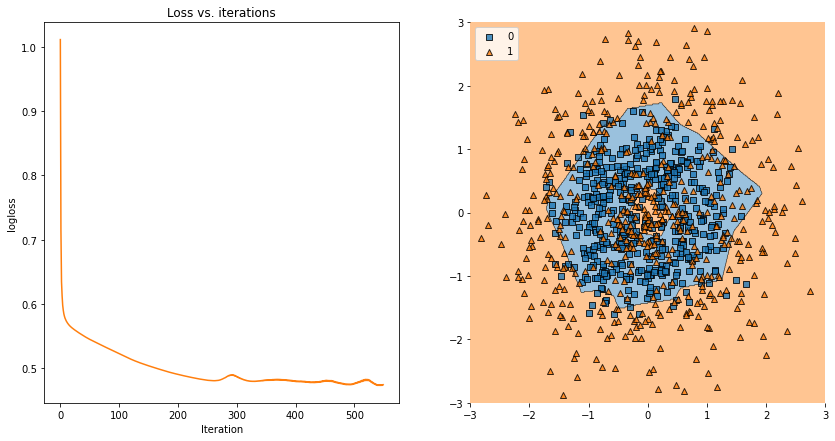

In [8]:
print("Best hyperparameters are (number_neurons, learining rate,  number iterations)", hyperpar_best)
print("Accuracy for test set is ", accuracy(Y_predict,ytest))
print("Roc for test set is ",roc_auc_score(Y_predict,ytest))
print("Table of classification report for test set \n", classification_report(Y_predict,ytest))

plt.figure(figsize=(14,7))

plt.subplot(1,2,1)
shallow_net_best.plot_loss()

plt.subplot(1,2,2)
plot_decision_regions(Xtest, yT, shallow_net_best)
plt.ylim(-3.0, 3.0)
plt.xlim(-3.0, 3.0)
plt.legend(loc='upper left')

# Deep neural network #


In this second we define a class for a deeper neural network, with 2 hidden layers.

- input layer
- hidden layer 1: activation function --> relu 
- hidden layer 2: activation function --> relu 
- output layer: activation function --> sigmoid





In [9]:
#depth is the number of layers: depth = 3
class DeeperNetwork():
    
    #initializations of parameters    
    def __init__(self, layers=[2,8,10,1], learning_rate=0.001, iterations=100):
        self.params = {}
        self.layers = layers
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.loss = []
        self.eps=0.00001 #risolve i problemi delle divisioni per 0
        self.sample_size = None
        self.X = None
        self.y = None
                
    
    def init_weights(self):
        np.random.seed(1) # Seed the random number generator
        self.params["W1"] = np.random.randn(self.layers[0], self.layers[1]) 
        self.params['b1'] = np.random.randn(self.layers[1],)
        self.params['W2'] = np.random.randn(self.layers[1],self.layers[2]) 
        self.params['b2'] = np.random.randn(self.layers[2],)
        self.params['W3'] = np.random.randn(self.layers[2],self.layers[3]) 
        self.params['b3'] = np.random.randn(self.layers[3],)
        
    def relu(self,Z):
        return np.maximum(0, Z) 
        
    def sigmoid(self,x):
            z = np.exp(-x+self.eps)
            return 1 / (1 + z)
    
    def cross_entropy_loss(self,y, yhat):
        nsample = len(y)
        loss = -1/nsample * (np.sum(np.multiply(np.log(yhat+self.eps), y+self.eps) + np.multiply((1 - y), np.log(1 - yhat+self.eps))))
        return loss

    def forward_propagation(self):
        
        Z1 = self.X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        A2 = self.relu(Z2)
        Z3 = A2.dot(self.params['W3']) + self.params['b3']
        
        yhat = self.sigmoid(Z3)
        loss = self.cross_entropy_loss(self.y,yhat)

        # save calculated parameters     
        self.params['Z1'] = Z1
        self.params['Z2'] = Z2
        self.params['A1'] = A1
        self.params['Z3'] = Z3
        self.params['A2'] = A2
        return yhat,loss

    
    def back_propagation(self,yhat):
        '''
        Computes the derivatives and update weights and bias according.
        '''
        def dRelu(x):
            x[x<=0] = 0
            x[x>0] = 1
            return x
        
        #dl_wrt_yhat derivative of loss with respect to
        dl_wrt_yhat = -(np.divide(self.y,yhat+self.eps) - np.divide((1 - self.y),(1-yhat+self.eps))) 
        dl_wrt_sig = yhat * (1-yhat)
        dl_wrt_z3 = dl_wrt_yhat * dl_wrt_sig
        dl_wrt_w3 = self.params['A2'].T.dot(dl_wrt_z3)
        dl_wrt_A2 = dl_wrt_z3.dot(self.params['W3'].T)
        dl_wrt_z2 = dl_wrt_A2 * dRelu(self.params['Z2'])
        dl_wrt_A1 = dl_wrt_z2.dot(self.params['W2'].T)
        
        dl_wrt_w2 = self.params['A1'].T.dot(dl_wrt_z2)
        dl_wrt_b2 = np.sum(dl_wrt_z2, axis=0)

        dl_wrt_z1 = dl_wrt_A1 * dRelu(self.params['Z1'])
        dl_wrt_w1 = self.X.T.dot(dl_wrt_z1)
        dl_wrt_b1 = np.sum(dl_wrt_z1, axis=0)
        dl_wrt_b3= np.sum(dl_wrt_z3, axis=0)
        
        #update the weights and bias
        self.params['W1'] = self.params['W1'] - self.learning_rate * dl_wrt_w1
        self.params['W2'] = self.params['W2'] - self.learning_rate * dl_wrt_w2
        self.params['W3'] = self.params['W3'] - self.learning_rate * dl_wrt_w3
        self.params['b1'] = self.params['b1'] - self.learning_rate * dl_wrt_b1
        self.params['b2'] = self.params['b2'] - self.learning_rate * dl_wrt_b2
        self.params['b3'] = self.params['b3'] - self.learning_rate * dl_wrt_b3
        
    def fit(self, X, y):
        '''
        Trains the neural network using the specified data and labels
        '''
        self.X = X
        self.y = y
        self.init_weights() #initialize weights and bias


        for i in range(self.iterations):
            yhat, loss = self.forward_propagation()
            self.back_propagation(yhat)
            self.loss.append(loss)
            
            
    def predict(self, X):
        '''
        Predicts on a test data
        '''
        Z1 = X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        A2 = self.relu(Z2)
        Z3 = A2.dot(self.params['W3']) + self.params['b3']
        pred = self.sigmoid(Z3)
        return np.round(pred)              

                                
    def acc(self, y, yhat):
        '''
        Calculates the accutacy between the predicted valuea and the truth labels
        '''
        acc = int(sum(y == yhat) / len(y) * 100)
        return acc


    def plot_loss(self):
        '''
        Plots the loss curve
        '''
        plt.plot(self.loss, 'C1')
        plt.xlabel("Iteration")
        plt.ylabel("logloss")
        plt.title("Loss vs. iterations")
        #plt.show()
    




In [10]:
score_tot=[]
parameters=[]
kf = KFold(n_splits=numK,shuffle=True, random_state=None)
for n in number_neurons: 
    print(n)
    for m in number_neurons: 
        for l_r in l_rates:
            #print(l_r)
            for it in number_iterations:
                #print(it)
                prediction=[]
                wtest=[]
                deep=DeeperNetwork(layers=[2,n, m, 1],learning_rate=l_r, iterations=it)
                for train_index, test_index in kf.split(Xtrain):
                    #print("TRAIN:", train_index, "TEST:", test_index)
                    X_train, X_test = Xtrain[train_index], Xtrain[test_index]
                    y_train, y_test = ytrain[train_index], ytrain[test_index]
                    deep.fit(X_train, y_train)
                    Y_predict=deep.predict(X_test)
                    prediction.extend(Y_predict)
                    wtest.extend(y_test)
                Roc=roc_auc_score(wtest, prediction)
                #print(Roc)
                score_tot.append(Roc)
                parameters.append((n,m,l_r, it))


4
7
10
13
16
19


Best hyperparameters are (neurons 1st hl,neurons 2nd hd, learining rate,  number iterations)
(16, 16, 4.641588833612782e-05, 550)
Accuracy for test set is  0.749
Roc for test set is  0.7538699690402476
Table of classification report for test set 
               precision    recall  f1-score   support

         0.0       0.81      0.70      0.75       544
         1.0       0.69      0.81      0.75       456

    accuracy                           0.75      1000
   macro avg       0.75      0.75      0.75      1000
weighted avg       0.76      0.75      0.75      1000



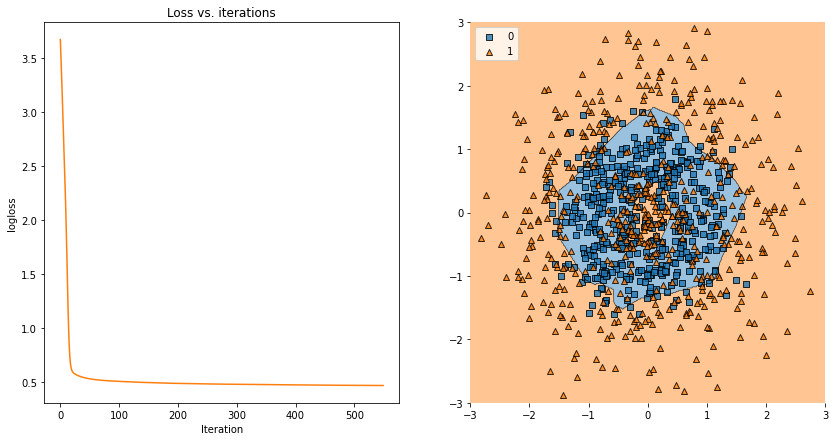

In [11]:
hyperpar_best= parameters[np.argmax(score_tot)]
n_best=hyperpar_best[0]
m_best=hyperpar_best[1]
l_r_best=hyperpar_best[2]
It_max_best=hyperpar_best[3]
deep_net_best=DeeperNetwork(layers=[2,n_best, m_best, 1],learning_rate=l_r_best, iterations=It_max_best)


deep_net_best.fit(Xtrain, ytrain)
Y_predict=deep_net_best.predict(Xtest)

print("Best hyperparameters are (neurons 1st hl,neurons 2nd hd, learining rate,  number iterations)")
print(hyperpar_best)
print("Accuracy for test set is ", accuracy(Y_predict,ytest))
print("Roc for test set is ",roc_auc_score(Y_predict,ytest))
print("Table of classification report for test set \n", classification_report(Y_predict,ytest))

plt.figure(figsize=(14,7))

plt.subplot(1,2,1)
deep_net_best.plot_loss()

plt.subplot(1,2,2)
plot_decision_regions(Xtest, yT, deep_net_best)
plt.ylim(-3.0, 3.0)
plt.xlim(-3.0, 3.0)
plt.legend(loc='upper left')